### Data Generation

In [3]:
import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt

In [4]:
time_steps = []
n, x = 100000, 0.3
for s in range(200):
    x = np.random.binomial(n = n, p = x) / n
    time_steps.append(x)

In [5]:
#generate ditribution at final time step
p = time_steps[-1]

samps = np.random.binomial(n = n, p = p, size= 10000) / n

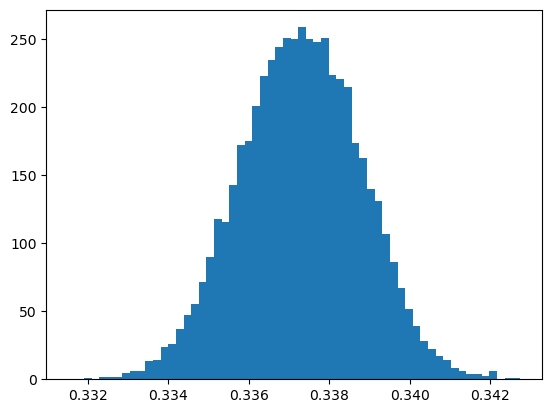

In [6]:

plt.hist(samps, bins = 'auto', density = True)
plt.show()

In [7]:
# Generate index values as a separate column
index_column = list(range(len(time_steps)))

#time_steps is a list of lists, where each inner list has 9 elements (for 9 regions)
column_names = ["Date", "Region_1"]

# Set a synthetic datetime index with weekly frequency starting from a specific date (This is necessary for the transformer input)
date_index = pd.date_range(start='2023-01-01', periods=len(time_steps), freq='W')

data = pd.DataFrame({
    'Date': date_index,
    'Value': time_steps
})

# Save the DataFrame to CSV without the default DataFrame index
data.to_csv("Univariate_MOIRAI/random_walk.csv", index=False)

### Generate Predictions

In [8]:
import os
import subprocess
import json

In [9]:
# Base paths for the folders
base_path = os.getcwd()
univariate_path = os.path.join(base_path, "Univariate_MOIRAI")

uni_predictions = os.path.join(base_path, "Univariate_MOIRAI/forecast.npy")

# Unified configuration file
config_path = os.path.join(base_path, "config.json")

# Docker images
docker_images = {
    "multivariate": "multivariate_moirai_image",
    "univariate": "univariate_moirai_image",
}

In [10]:
## Definitions

def build_docker(container_type):
    """
    Build the Docker image for the specified container type.
    """
    if container_type not in ["multivariate", "univariate"]:
        raise ValueError(f"Invalid container type: {container_type}")
    
    folder_path = multivariate_path if container_type == "multivariate" else univariate_path
    docker_image = docker_images[container_type]
    
    print(f"Building Docker image for {container_type}...")
    
    try:
        subprocess.run(
            ["docker", "build", "-t", docker_image, folder_path],
            check=True
        )
    except subprocess.CalledProcessError as e:
        print(f"Error building {container_type} image: {e}")
        raise
def run_multiple(docker_image):
    """Load configs and execute multiple runs."""
    with open("config.json", "r") as f:
        config = json.load(f)


    for i, run_config in enumerate(config["runs"]):
        print(f"Running configuration {i + 1}/{len(config['runs'])}: {run_config}")
        run_docker_with_params(run_config, docker_image, f"run_{i + 1}")

def run_docker_with_params(config, docker_image, run_name):
    """Run Docker container with parameters."""
    # Save temp config file for this run
    temp_config_path = os.path.join("/tmp", f"temp_config_{run_name}.json")
    with open(temp_config_path, "w") as temp_config:
        json.dump(config, temp_config)

    folder_path =  univariate_path

    # Run Docker container with mounted temp config
    subprocess.run(
        [
            "docker", "run", 
            "-v", f"{temp_config_path}:/app/config.json",  # Mount temp config
            "-v", f"{folder_path}:/app",  # Mount repository
            docker_image
        ],
        check=True
    )

In [13]:
build_docker("univariate")

Building Docker image for univariate...


#0 building with "desktop-linux" instance using docker driver

#1 [internal] load build definition from Dockerfile
#1 transferring dockerfile: 1.19kB done
#1 DONE 0.0s

#2 [internal] load metadata for docker.io/library/python:3.10-slim
#2 DONE 0.4s

#3 [internal] load .dockerignore
#3 transferring context: 2B done
#3 DONE 0.0s

#4 [internal] load build context
#4 transferring context: 208B done
#4 DONE 0.0s

#5 [1/9] FROM docker.io/library/python:3.10-slim@sha256:bdc6c5b8f725df8b009b32da65cbf46bfd24d1c86dce2e6169452c193ad660b4
#5 resolve docker.io/library/python:3.10-slim@sha256:bdc6c5b8f725df8b009b32da65cbf46bfd24d1c86dce2e6169452c193ad660b4 0.0s done
#5 DONE 0.0s

#6 [6/9] RUN pip install --no-cache-dir torch torchvision torchaudio
#6 CACHED

#7 [4/9] RUN pip install --no-cache-dir --upgrade pip
#7 CACHED

#8 [5/9] RUN pip install --no-cache-dir --upgrade "jax[cpu]" -f https://storage.googleapis.com/jax-releases/jax_releases.html
#8 CACHED

#9 [7/9] RUN pip install numpy
#9 CACHED

#

In [14]:
run_multiple(docker_images["univariate"])

Running configuration 1/1: {'CTX': 200, 'PDT': 1, 'BSZ': 32, 'PSZ': 'auto', 'data_set': 'random_walk.csv', 'NSP': 10000}
DataFrame index frequency: <Week: weekday=6>
DataFrame columns: ['Value']
Forecast 0: samples shape = (10000, 1)


In [15]:
forecast_path = os.path.join(univariate_path, "forecast.npy")
forecast = np.load(forecast_path).flatten()

### Plots

In [34]:
import scipy
from scipy.stats import entropy
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

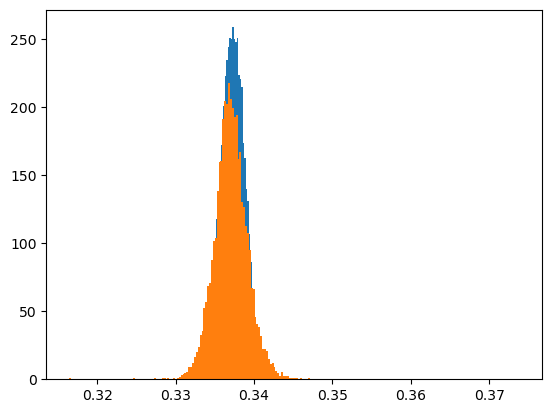

In [40]:
plt.hist(samps, bins = 'auto', density = True)
plt.hist(forecast, bins = 'auto', density = True)
plt.show()


In [35]:
kl_divergence = entropy(samps, forecast )
print(f"KL Divergence: {kl_divergence}")

KL Divergence: 3.3213769656916794e-05


In [45]:

def KDE_plots(samples, prediction):
    """Generate and display KDE plots for sample and prediction distributions with adjusted x-axis scaling.
    
    Parameters:
    samples (list or array): The true sample data for comparison.
    prediction (list or array): The predicted data to compare against the samples.
    save_as (str): File path to save the resulting plot.
    
    Returns:X
    None
    """

    data_list = []
    
    for value in prediction:
        data_list.append({'Deme': 1, 'Type': 'Predictions', 'Value': value})
    for value in samples:
        data_list.append({'Deme': 1, 'Type': 'Truth', 'Value': value})
    
    # Convert list to DataFrame
    df_long = pd.DataFrame(data_list)
    
    # Define a suitable x-axis range
    x_min, x_max = df_long["Value"].min(), df_long["Value"].max()
    
    # Create the KDE plots with explicit x-axis range
    g = sns.FacetGrid(df_long, col="Deme", hue="Type", sharex=True, sharey=True, height=4)
    g.map(sns.kdeplot, "Value", fill=True, alpha=0.5, clip=(x_min, x_max), bw_adjust=0.5)
    
    # Add titles and legend
    g.add_legend(title="Type")
    g.set_axis_labels("Frequency", "Density")
    g.set_titles("{col_name}")
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle("KDE Plots")
    
    # Adjust x-axis scaling manually for each plot
    for ax in g.axes.flatten():
        ax.set_xlim(x_min, x_max)
    
    # Save the plot
    plt.show()


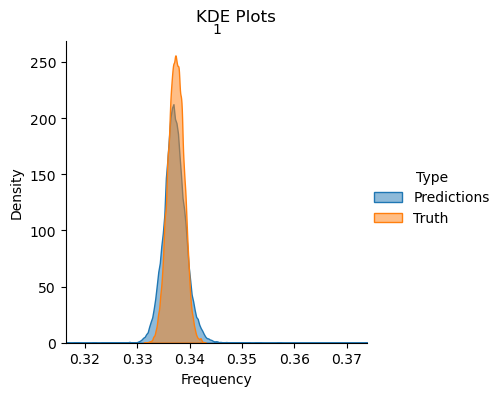

In [46]:
KDE_plots(samps, forecast)

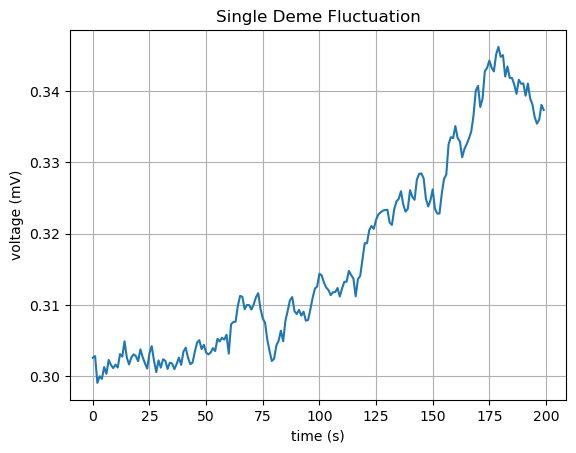

In [25]:
fig, ax = plt.subplots()
ax.plot(time_steps)

ax.set(xlabel='time (s)', ylabel='voltage (mV)',
       title='Single Deme Fluctuation')
ax.grid()
plt.show()